##Loading data

This dataset consists of dogs and cats images. The data set is devided into 25000 images for training and 12500 images for testing. The evaluation criteria is Accuracy. The data can be found here ( https://www.kaggle.com/c/dogs-vs-cats/overview )  

In [2]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!kaggle -v

Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
     |████████████████████████████████| 1.5MB 4.5MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 58 kB 2.6 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72859 sha256=fa6a780a609106796afdea5b70fb7af90064e98e53d124ba47a3fe213bcd53c4
  Stored in directory: /root/.cache/pip/wheels/01/3e/ff/77407ebac3ef71a79b9166a8382aecf88415a0bcbe3c095a01
Successfully built kaggle
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.6/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.6/dist-packages/kaggle/api/kaggle_api_extended.py", line 149, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure

In [3]:
!mkdir ~/.kaggle/
!mv kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json 
!kaggle competitions download -c dogs-vs-cats

mkdir: cannot create directory ‘/root/.kaggle/’: File exists
100% 809M/812M [00:03<00:00, 273MB/s]
100% 812M/812M [00:03<00:00, 235MB/s]


In [4]:
!unzip dogs-vs-cats.zip

Archive:  dogs-vs-cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


In [5]:
!unzip test1.zip
!unzip train.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       
  inflating: train/dog.5520.jpg      

## Import all the required libraries
---
1. pandas for data management 
2. seaborn and matplotlib for plotting
3. os to read image data
4. tensorflow for building models
5. plot_model from keras to plot model
6. metrics from sklearn to check model performance
7. train_test_split from sklearn to split data into training and validation.

In [93]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import tensorflow as tf
from os import listdir
from os.path import isfile, join
from keras.utils.vis_utils import plot_model
import cv2
import sklearn.metrics
from sklearn.model_selection import train_test_split

## Read the files in the directory and plot images

In [94]:
onlyfiles = [f for f in listdir('/content/train') if isfile(join('/content/train', f))]

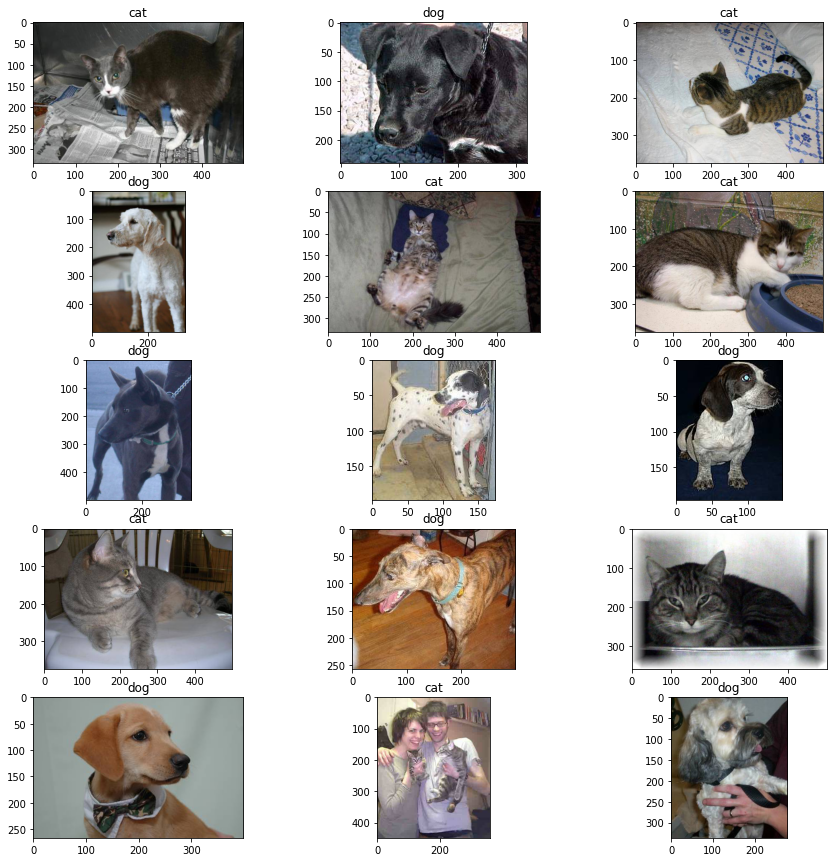

In [9]:
plt.figure(figsize=(15,15))
for i in range(15):
  plt.subplot(5,3,i+1)
  image = 'train/' + str(onlyfiles[i])
  image = plt.imread(image)
  plt.title(onlyfiles[i][:3])
  plt.imshow(np.asarray(image))

In [95]:
labels = []
for name in onlyfiles:
  if name[:3] == 'dog':
    labels.append('1')
  else:
    labels.append('0')

In [96]:
labels = np.asarray(labels, dtype=str)

In [97]:
data = pd.DataFrame({'image':onlyfiles, 'names':labels})

##split the dataframe into train and validate
split the data in 9:1 ratio as the dataset size pretty big but not very huge. As the dataset size increases increase the training proportion

In [98]:
train_data, validate = train_test_split(data, test_size=0.1, random_state=42)
train_data = train_data.reset_index(drop=True)
validate = validate.reset_index(drop=True)

## Data augmentation
___

Here for data augmentation is done with imagedatagenerator from keras preprocessing.
data augmentation helps model to generalize.

here random zoom , random rotation, horizontal flip is added to augment the image. because model may encounter images where subject is bigger or oriented in different direction. This augmentation trains the model to predict new images more accurately



In [15]:
imagegenerator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range = 30,
    zoom_range = 0.3,
    horizontal_flip = True,
)

In [16]:
validationimagegenerator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

The flow from dataframe comes in handy when we have low ram in the system, as it reads, augments and trains the data in smaller packs, there is no need to load all the data to your ram befor training.

The downside is it will take more time compared to loading the image into ram and then runing, and also **we can not run the models on TPUs**.

In [17]:
train = imagegenerator.flow_from_dataframe(train_data , directory='train/', x_col='image',
                                          y_col = 'names',class_mode='binary', batch_size = 128, target_size=(160,160))

Found 22500 validated image filenames belonging to 2 classes.


In [18]:
valid = validationimagegenerator.flow_from_dataframe(validate , directory='train/', x_col='image',
                                          y_col = 'names',class_mode='binary', batch_size = 128, target_size=(160,160))

Found 2500 validated image filenames belonging to 2 classes.


## Transfer learning and fine tuning
In this notebook the model is built with transfer learning using inceptionv3 as base model.


InceptionV3 is the third version of inception, here the model is loaded with imagenet weights.

The inceptionV3 consists of overall 311 layers ( including activation layers )


###Fine Tuning

Fine tuning is required get the best model out of the architecture for perticular problem.

There are many methods to fine tune model, to know which layers to freeze and which layers to train.

We can plot the output from the model at different layers for our subject's image, and by closely examining and training at best probable location will lead to the best model.

We can use different learning rates at different layers, with this shallow layes learn more and deeper layers learn less.

In this notebook inception model is plotted and closely examined to get the best possible layers to train. The inception model is keenly observed, and concatenation layers are choosen line between trainable layers and freezing layers.

Many concatenation layers are choosen as nodes and network is trained, as we go deeper the training time increases, if we choose shallow nodes the model fails to learn fewatures perticular to the problem. By dooing this we get a perfect node where the valoidation accuracy is highest.


In [25]:
base_model = tf.keras.applications.InceptionV3(include_top=False, input_shape=(160,160,3))

87916544/87910968 [==============================] - 1s 0us/step


In [32]:
plot_model(base_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

This archetecture produces best accuracy when we freeze layers till 248th layer which is a concatenation layer

In [36]:
base_model.trainable = True
for layer in base_model.layers[:248]:
  layer.trainable =  False

To avoide overfitting of the model to train set the model is punished with higher loss when it tries increase the weights which helps in regularizing the model.

Inception comes with no regularizers added so the conv2d layers till the choosen node are added l2 regularizer.

In [ ]:
for i in range(len(base_model.layers)):
  if 'conv2d' in str(base_model.layers[i].name):
    if i>248:
      base_model.layers[i].kernel_regularizer = tf.keras.regularizers.l2(0.02)

In [39]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 79, 79, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 79, 79, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 79, 79, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

On the top of base model dense layer with relu activation and an output layer with sigmoid ( as it is a binary classification ) activation is used.

To train model Adam ( Adaptive Momentum ) optimizer is used as it combines rmsprop and momentum algorithms to optimize the model as early as possible.

In [41]:
model = tf.keras.Sequential([
                            base_model,
                            tf.keras.layers.Flatten(),
                            tf.keras.layers.Dense(32, activation='relu'),
                            tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model checkpoint callback from tensorflow callbacks, which saves the best weights for model, is used.

In [42]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    '/content/check_points', monitor='val_loss', save_freq='epoch'
)

## Model Training

the model is trained for 20 epochs get the 98% accuracy after which the validation accuracy platues 

In [44]:
history = model.fit_generator(train, epochs=10, validation_data=valid, callbacks=[model_checkpoint_callback])

Epoch 1/10
176/176 [==============================] - 204s 1s/step - loss: 0.0242 - accuracy: 0.9906 - val_loss: 0.0678 - val_accuracy: 0.9812
Epoch 2/10
176/176 [==============================] - 202s 1s/step - loss: 0.0232 - accuracy: 0.9920 - val_loss: 0.0680 - val_accuracy: 0.9808
Epoch 3/10
176/176 [==============================] - 202s 1s/step - loss: 0.0215 - accuracy: 0.9926 - val_loss: 0.0684 - val_accuracy: 0.9816
Epoch 4/10
176/176 [==============================] - 203s 1s/step - loss: 0.0244 - accuracy: 0.9908 - val_loss: 0.0683 - val_accuracy: 0.9816
Epoch 5/10
176/176 [==============================] - 202s 1s/step - loss: 0.0208 - accuracy: 0.9922 - val_loss: 0.0690 - val_accuracy: 0.9820
Epoch 6/10
176/176 [==============================] - 203s 1s/step - loss: 0.0241 - accuracy: 0.9904 - val_loss: 0.0680 - val_accuracy: 0.9820
Epoch 7/10
176/176 [==============================] - 203s 1s/step - loss: 0.0225 - accuracy: 0.9916 - val_loss: 0.0683 - val_accuracy: 0.9820

## Model Evaluation

load the validation data

In [149]:
X = np.empty((2500, 160,160,3))
for idx, id in enumerate(validate.image):
    file_path =  os.path.join('train/', id)
    image = cv2.imread(file_path)
    image= cv2.resize(image, (160, 160))
    image = np.array(image, dtype=np.float64)
    image = image/255
    X[idx,] = image

In [61]:
output = model.predict(X)

In [62]:
for i in range(len(output)):
  if output[i]<0.5:
    output[i] = 0
  else:
    output[i] = 1

confusion matrix is the matrix or True positive, True negative False positive, false negative. Which helps us decide which model is performing better foer which class

According to the below confusion matrix 64 images are classified incorrectly

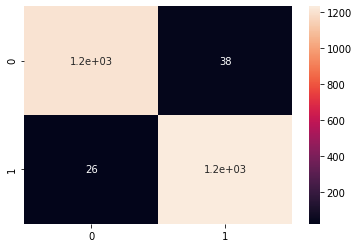

In [101]:
confusion = sklearn.metrics.confusion_matrix(validate.names.astype(int), output)
sns.heatmap(confusion, annot=confusion)

precision and recall are obtained from the confusion matrix, f1 score is derived from the precision and recall metrics. More the scores better is the model

In [67]:
report = sklearn.metrics.classification_report(validate.names.astype(int), output, target_names=['dog','cat'])

In [68]:
print(report)

              precision    recall  f1-score   support

         cat       0.98      0.97      0.97      1244
         dog       0.97      0.98      0.97      1256

    accuracy                           0.97      2500
   macro avg       0.97      0.97      0.97      2500
weighted avg       0.97      0.97      0.97      2500



AUC score also a good metrics to decide the better model and it also helps in obtaining correct threshold value, Better the auc score better the model.

In [74]:
sklearn.metrics.roc_auc_score(validate.names.astype(int), output)

0.9743763696315563

In [87]:
false_prediction = []
for i in range(len(output)):
  if output[i] != validate.names.astype(int)[i]:
    false_prediction.append(validate.image[i])

## plotting some images which were predicted incorrectly
---

We can see there are many noise in these images. It's impossible to predict the first image as cat for even humans, the last image has a doll of dog which must have confused the model





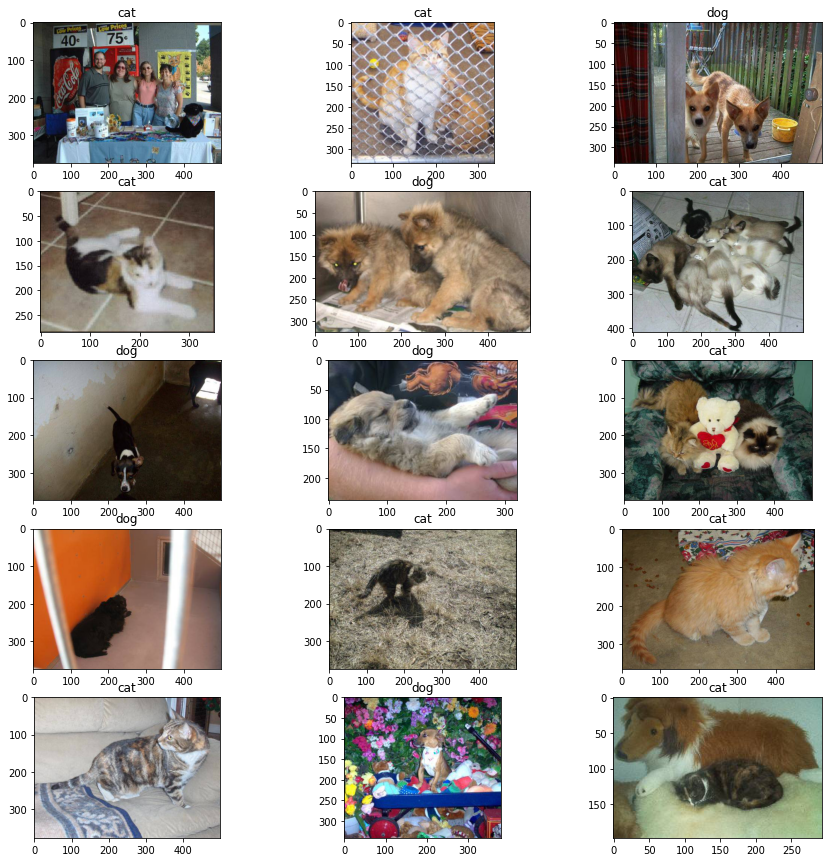

In [91]:
plt.figure(figsize=(15,15))
for i in range(15):
  plt.subplot(5,3,i+1)
  image = 'train/' + str(false_prediction[i])
  image = plt.imread(image)
  plt.title(false_prediction[i][:3])
  plt.imshow(np.asarray(image))

## Ensembling
One of the best practices to push the performances of the model is to ensemble many independently trained models.

In the same way this model is built, A model with mobilenet archetecture and another with resnet are trained in another notebooks parallally

In [103]:
inception = tf.keras.models.load_model('/content/drive/My Drive/check_points_inception3')

In [104]:
mobilenet = tf.keras.models.load_model('/content/drive/My Drive/check_points(mobile_net)')

In [105]:
resnet = tf.keras.models.load_model('/content/drive/My Drive/check_pointsresnet')

In [150]:
inception_output = inception.predict(X)
mobilenet_output = mobilenet.predict(X)
resnet_output = resnet.predict(X)

In [108]:
model_outputs = [inception_output, mobilenet_output, resnet_output]
for model in  model_outputs:
  for i in range(len(model)):
    if model[i]<0.5:
      model[i] = 0
    else:
      model[i] = 1

###Comparing all three models 

With all the above metrics all the 3 models are evaluated, After looking at this we can say They are almost similar in performance when they are used alone.

But on ensembling all the three models, we can see it performing better than every model when considered alone. accuracy has gone up from 0.97 to 0.98.

              precision    recall  f1-score   support

         dog       0.98      0.97      0.97      1244
         cat       0.97      0.98      0.97      1256

    accuracy                           0.97      2500
   macro avg       0.97      0.97      0.97      2500
weighted avg       0.97      0.97      0.97      2500

AUC Score : 0.9743763696315563
              precision    recall  f1-score   support

         dog       0.98      0.95      0.97      1244
         cat       0.96      0.98      0.97      1256

    accuracy                           0.97      2500
   macro avg       0.97      0.97      0.97      2500
weighted avg       0.97      0.97      0.97      2500

AUC Score : 0.9699282671472751
              precision    recall  f1-score   support

         dog       0.98      0.97      0.97      1244
         cat       0.97      0.98      0.97      1256

    accuracy                           0.97      2500
   macro avg       0.97      0.97      0.97      2500
weighted avg

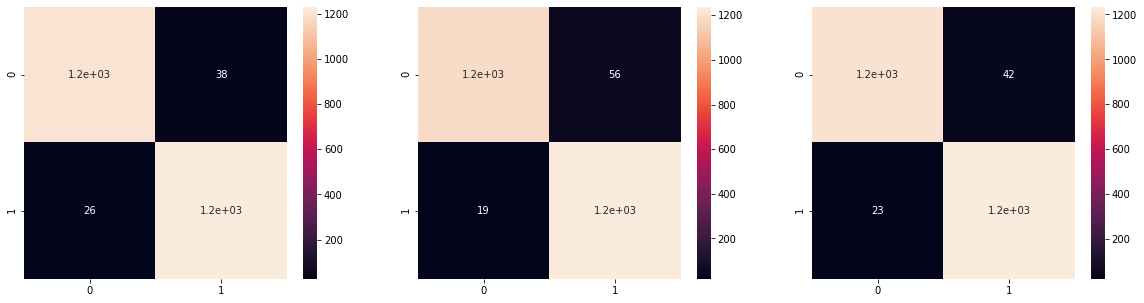

In [133]:
plt.figure(figsize=(20,5))
for i in range(3):
  confusion = sklearn.metrics.confusion_matrix(validate.names.astype(int), model_outputs[i])
  plt.subplot(1,3,i+1)
  sns.heatmap(confusion, annot=confusion)
  print(sklearn.metrics.classification_report(validate.names.astype(int), model_outputs[i], target_names=['dog','cat']))
  print('AUC Score : ' + str(sklearn.metrics.roc_auc_score(validate.names.astype(int), model_outputs[i])))

In [ ]:
inception_output = inception.predict(X)
mobilenet_output = mobilenet.predict(X)
resnet_output = resnet.predict(X)

In [151]:
ensemble = []
for i in range(len(output)):
  a = inception_output[i] + mobilenet_output[i] + resnet_output[i]
  if a>1.5:
    ensemble.append(1)
  else:
    ensemble.append(0)


In [152]:
ensemble = np.asarray(ensemble, int)

              precision    recall  f1-score   support

         dog       0.99      0.97      0.98      1244
         cat       0.97      0.99      0.98      1256

    accuracy                           0.98      2500
   macro avg       0.98      0.98      0.98      2500
weighted avg       0.98      0.98      0.98      2500

AUC score0.9799611383046266


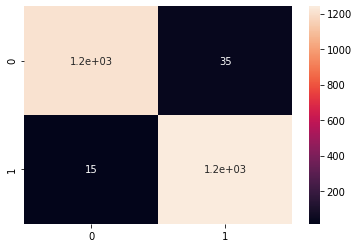

In [153]:
confusion = sklearn.metrics.confusion_matrix(validate.names.astype(int), ensemble)
sns.heatmap(confusion, annot=confusion)
print(sklearn.metrics.classification_report(validate.names.astype(int), ensemble, target_names=['dog','cat']))
print('AUC score' + str(sklearn.metrics.roc_auc_score(validate.names.astype(int), ensemble)))

## Testing the model with images taken from other sources



This is a very common looking cat image and model has predicted correctly

this is a cat


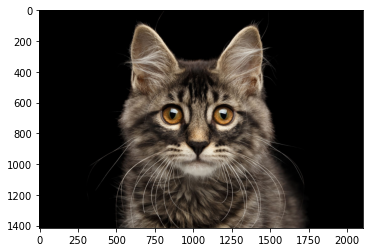

In [145]:
X = np.empty((1, 160,160,3))
image = plt.imread('/content/578211-gettyimages-542930526.jpg')
plt.imshow(image)
image= cv2.resize(image, (160, 160))
image = np.array(image, dtype=np.float64)
image = image/255
X[0,] = image
a = inception.predict(X)[0] + mobilenet.predict(X)[0] + resnet.predict(X)[0]
if a>1.5:
  print('this is a dog')
else:
  print('this is a cat')

This is a very common looking puppy image and model has predicted correctly

this is a dog


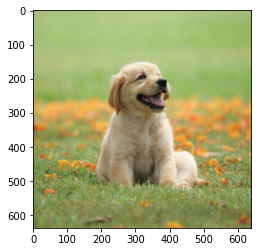

In [146]:
X = np.empty((1, 160,160,3))
image = plt.imread('/content/dog-puppy-on-garden-royalty-free-image-1586966191.jpg')
plt.imshow(image)
image= cv2.resize(image, (160, 160))
image = np.array(image, dtype=np.float64)
image = image/255
X[0,] = image
a = inception.predict(X)[0] + mobilenet.predict(X)[0] + resnet.predict(X)[0]
if a>1.5:
  print('this is a dog')
else:
  print('this is a cat')

This is a dog wearing mask to protect you against **COVID-19** even when appale face recognise you with your mask our model has predicted correctly

this is a dog


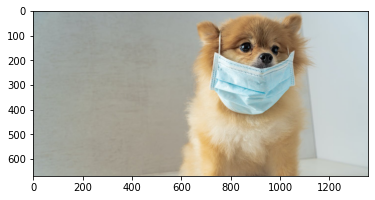

In [147]:
X = np.empty((1, 160,160,3))
image = plt.imread('/content/file-20200309-118956-1cqvm6j.jpg')
plt.imshow(image)
image= cv2.resize(image, (160, 160))
image = np.array(image, dtype=np.float64)
image = image/255
X[0,] = image
a = inception.predict(X)[0] + mobilenet.predict(X)[0] + resnet.predict(X)[0]
if a>1.5:
  print('this is a dog')
else:
  print('this is a cat')

Model is sure, this wierdly looking animal is cat

this is a cat


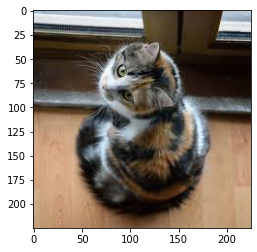

In [148]:
X = np.empty((1, 160,160,3))
image = plt.imread('/content/images.jpg')
plt.imshow(image)
image= cv2.resize(image, (160, 160))
image = np.array(image, dtype=np.float64)
image = image/255
X[0,] = image
a = inception.predict(X)[0] + mobilenet.predict(X)[0] + resnet.predict(X)[0]
if a>1.5:
  print('this is a dog')
else:
  print('this is a cat')